# Project DEFI: Decision-Feedback Equalizer Implementation

**Objective:** Use a Decision Feedback Equalizer to mitigate Interference Inter Sysmbol in a simple digital channel.

This notebook can leverages example of **PySDR** available at :
https://github.com/777arc/PySDR/tree/ba4f470767bbd5b460217ec2f78ade82845c15e8/figure-generating-scripts


## 1. Import Required Libraries

In [ ]:
%pip install --upgrade pip setuptools wheel

%pip install -r ../requirements.txt

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from utils import add_awgn_noise, plot_eye


## 2. Simulate ISI Channel
- Create a simple 2-tap channel.
- Generate BPSK symbols and pass them through the channel.

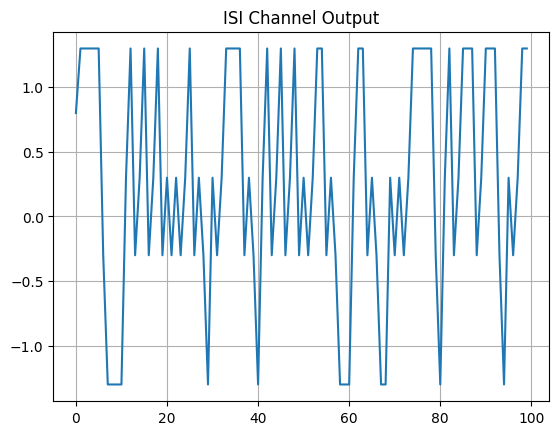

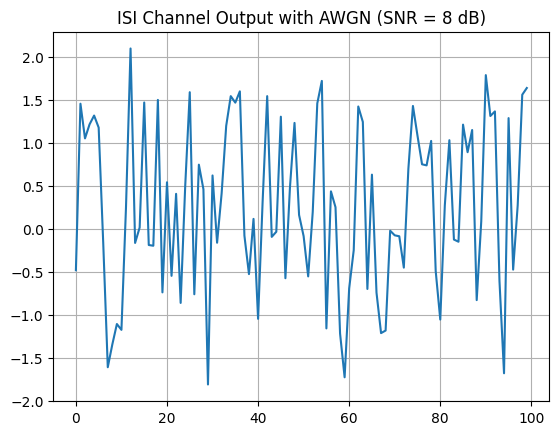

In [ ]:
# TODO: ISI channel simulation
num_symbols = 2000
bits = np.random.randint(0, 2, num_symbols)
symbols = 2*bits - 1

# 2-tap channel: h[n] = [0.8, 0.5]
isi_channel = np.array([0.8, 0.5])
received = np.convolve(symbols, isi_channel, mode='same')

plt.figure()
plt.plot(received[:100])
plt.title('ISI Channel Output')
plt.grid()
plt.show()

snr_db = 10
received_noisy = add_awgn_noise(received, snr_db)

plt.plot(received_noisy[:100])
plt.title(f'ISI Channel Output with AWGN (SNR = {snr_db} dB)')
plt.grid(True)
plt.show()

## 3. Visualize ISI Effects (Eye Diagram)

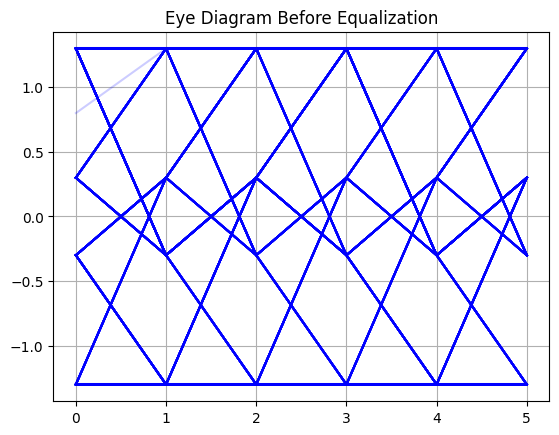

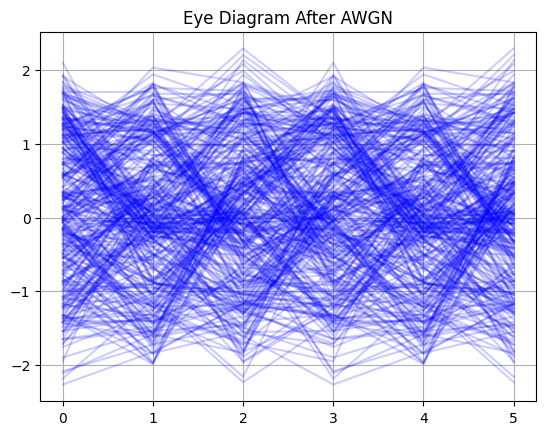

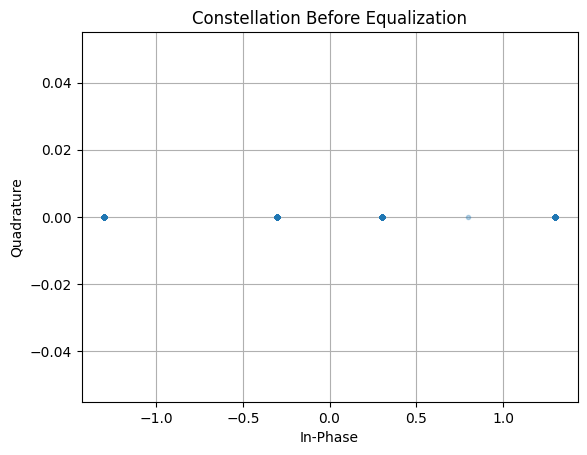

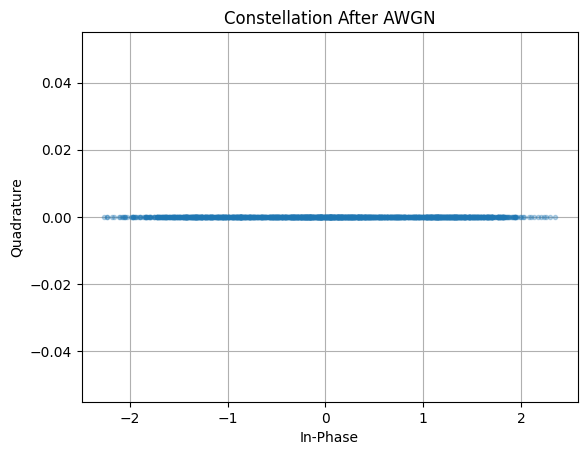

In [202]:
# TODO: Eye diagram before equalization
#digital.plot_eye(received, sps=1)

# Eye Diagram
plot_eye(received, sps=3, title ='Eye Diagram Before Equalization')

plot_eye(received_noisy, sps=3, title ='Eye Diagram After AWGN')

sps = 1
# Constellation Plot
plt.figure()
plt.plot(received[::sps], np.zeros_like(received[::sps]), '.', alpha=0.3)
plt.title('Constellation Before Equalization')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(received_noisy[::sps], np.zeros_like(received_noisy[::sps]), '.', alpha=0.3)
plt.title('Constellation After AWGN')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.show()




Simple DEF

Final h1: 0.5019755419803856, Final h2: 0.0017322916873199266
mu: 5e-05


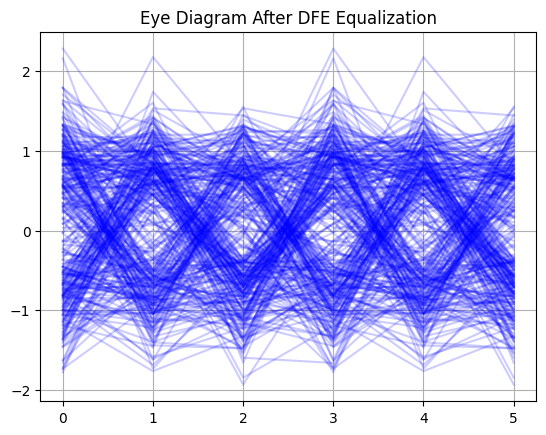

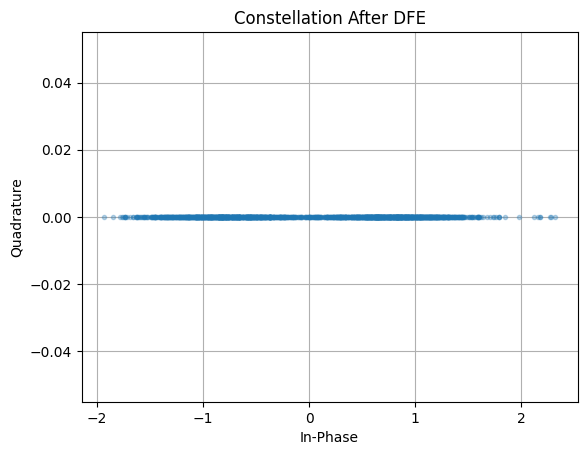

In [203]:
# TODO: Implement basic DFE equalizer

def two_tap_dfe(received, symbols, mu=0.0001):
    N = len(received)
    decisions = np.zeros(N)
    dfe_output = np.zeros(N)

    h1 = 0.5
    h2 = 0.0
    h1_list = []
    h2_list = []

    # Initialize first two decisions to first two symbols to start feedback
    decisions[0] = symbols[0]
    decisions[1] = symbols[1]

    for i in range(2, N):
        dfe_out = received[i] - h1 * decisions[i-1] - h2 * decisions[i-2]
        dfe_output[i] = dfe_out

        decisions[i] = 1 if dfe_out >= 0 else -1

        error = symbols[i] - dfe_out

        h1 += mu * error * decisions[i-1]
        h2 += mu * error * decisions[i-2]

        h1_list.append(h1)
        h2_list.append(h2)

    return dfe_output, decisions, h1_list, h2_list
mu = 1 / (len(symbols)*10)  # Adjust mu based on the number of symbols
dfe_output, decisions, h1_track, h2_track = two_tap_dfe(received_noisy, symbols, mu=mu)
print(f"Final h1: {h1_track[-1]}, Final h2: {h2_track[-1]}")
print(f"mu: {mu}")
# Eye Diagram after Equalization
plot_eye(dfe_output, sps=3, title='Eye Diagram After DFE Equalization',offset=2)


# Constellation after Equalization
plt.figure()
plt.plot(dfe_output[::sps], np.zeros_like(dfe_output[::sps]), '.', alpha=0.3)
plt.title('Constellation After DFE')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.show()



## 5. BER Analysis

In [204]:
# TODO: Compute BER before and after equalization.
decisions_bits = (decisions > 0).astype(int)

# Calculate BER before equalization

received_bits_before = (received_noisy > 0).astype(int)
bit_errors_before = np.sum(received_bits_before != bits)
ber_before = bit_errors_before / len(bits)

bit_errors_after = np.sum(decisions_bits != bits)
ber_after = bit_errors_after / len(bits)

print(f'BER before DFE equalization: {ber_before:.2e}')
print(f'BER after DFE equalization: {ber_after:.2e}')

# ber_after =  np.mean(decisions[2:] != symbols[2:])
# print(f"BER after LMS-based 2-Tap DFE: {ber_after:.5f}")

BER before DFE equalization: 1.07e-01
BER after DFE equalization: 1.70e-02


## 6. Reflection
- How does DFE mitigate ISI?
- Practical relevance (DSL, LTE, etc.).